In [14]:
import numpy as np
from ipywidgets import *
import matplotlib.pyplot as plt

c1 = 1 # Ratio of survival rate of H to P queens (used in queen fights within clusters)
c2 = 1 # Ratio of contribution of H to P queens (not currently used)
c3 = 1 # Ratio of reproductive capabilities of H to P queens (used in reproduction)
sc = 0.5 # Survival rate of P queens (used in queen fights within clusters)

s2 = 1 # Reproductive variance (sigma^2) (used in reproduction)

sims = 30 # Number of simulations to run and average
gens = 200 # Number of generations to simulate

In [2]:
class Cluster():
    def __init__(self, i, j, c1, sc):
        self.i = i
        self.j = j
        self.qc = 0 # Number of cooperative queens
        self.qs = 0 # Number of solitary queens
        self.c1 = c1
        self.sc = sc
        
    def potential(self):
        xi = self.qc + self.qs
        return -2.88 + 4.28 * xi - 0.377 * (xi ** 2)

    def queen_fight(self, Cm = 5):
        while (self.qc + self.qs) > Cm:
            self.qc = int(self.qc * self.sc)
            self.qs = int(self.qs * self.sc * self.c1)

In [3]:
class Landscape():
    def __init__(self, K, m, n):
        '''K: size of individual clusters (int)
           m x n: size of grid of clusters (int) (int)
           p: probability a queen is cooperative (double 0-1)'''
        self.K = K
        self.m = m
        self.n = n
        self.clusters = []
        for i in range(m):
            new_row = []
            for j in range(n):
                new_row.append(Cluster(i, j))
            self.clusters.append(new_row)

    def create_queens(self, qc = 0, qs = 0):
        '''Q: number of queens to populate the grid with (int)
            qc: a specific number of cooperative queens to include
            qs: a specific number of solitary queens to include'''

        # TODO RESTRICT INITIAL NUMBER OF QUEENS IN EACH CLUSTER TO ...

        locations = [x for x in range(self.K * self.K * self.m * self.n)]
        types = [0 for x in range(qc)] + [1 for x in range(qs)]
        np.random.shuffle(types)
        while len(types) > 0:
            new_position = locations.pop(np.random.randint(len(locations))) // (self.K * self.K)
            cluster = self.clusters[new_position // self.n][new_position % self.n]
            if types.pop() == 1:
                cluster.qs += 1
                qs -= 1
            else:
                cluster.qc += 1
                qc -= 1

    def queen_count(self):
        '''Count the number of P (cooperative) and H (solitary) queens on the whole landscape'''
        qc, qs = 0, 0
        for row in self.clusters:
            for cluster in row:
                qc += cluster.qc
                qs += cluster.qs
        return (qc, qs)

    def queen_fight(self):
        '''Simulate fights between queens within the clusters'''
        for row in self.clusters:
            for cluster in row:
                cluster.queen_fight()

    def cluster_fight(self):
        '''Simulate fights between all neighboring clusters'''
        '''total_potential = 0
        colonies = []
        for row in self.clusters:
            for cluster in row:
                if (cluster.qs + cluster.qc) > 0:
                    colonies.append(cluster)
                    total_potential += cluster.potential()
        for cluster in colonies:
            if np.random.uniform() > (cluster.potential() / total_potential):
                cluster.qc = 0
                cluster.qs = 0'''

        dead_colonies = []
        for i in range(self.m):
            for j in range(self.n):
                # Calculate total potential of all neighbors in Von Neumann neighborhood
                total_potential = 0
                for (x,y) in [(0,-1), (1,0), (0,1), (-1, 0)]:
                    if 0 <= i+x < self.m and 0 <= j+y < self.n:
                        total_potential += max(0, self.clusters[i+x][j+y].potential())
                if total_potential != 0:
                    if np.random.uniform() > self.clusters[i][j].potential() / total_potential:
                        dead_colonies.append(self.clusters[i][j])
        
        for colony in dead_colonies:
            colony.qc = 0
            colony.qs = 0
        
    def reproduce(self):
        C, S = 0, 0
        for row in self.clusters:
            for cluster in row:
                while cluster.qc > 0:
                    C += max(0, np.random.normal(1, s2))
                    #C += np.random.normal(1, s2)
                    cluster.qc -= 1
                while cluster.qs > 0:
                    S += max(0, np.random.normal(1, s2*c3))
                    #S += np.random.normal(1, s2*c3)
                    cluster.qs -= 1
        self.create_queens(qc = int(C), qs = int(S))

Button(description='Button', style=ButtonStyle())

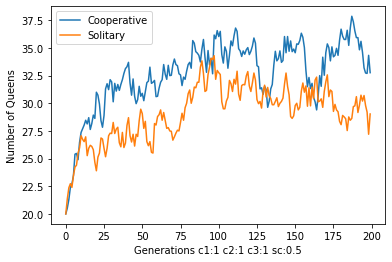

In [18]:
%matplotlib inline
button = Button(description="Button")
out = Output()

def on_button_clicked(b):
    
    qc_count_average = []
    qs_count_average = []

    for i in range(sims):
        land = Landscape(K = 30, m = 5, n = 5)
        land.create_queens(qc = 20, qs = 20)

        qc_counts = []
        qs_counts = []

        for j in range(gens):
            qc, qs = land.queen_count()
            qc_counts.append(qc)
            qs_counts.append(qs)

            land.queen_fight()

            #land.cluster_fight()

            land.reproduce()

        qc_count_average.append(np.array(qc_counts))
        qs_count_average.append(np.array(qs_counts))

    plt.plot(np.arange(gens), np.mean(qc_count_average, axis = 0), label = 'Cooperative')
    plt.plot(np.arange(gens), np.mean(qs_count_average, axis = 0), label = 'Solitary')
    plt.xlabel('Generations c1:' + str(c1) + ' c2:' + str(c2) + ' c3:' + str(c3) + ' sc:' + str(sc))
    plt.ylabel('Number of Queens')
    plt.legend()
    plt.show()

button.on_click(on_button_clicked)
display(button)